In [ ]:
# Import packages
import numpy as np
import cv2
import struct
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [4]:

def read_mnist_images(filename: str) -> List[np.ndarray]:
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return [img for img in images]

def read_mnist_labels(filename: str) -> List[int]:
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels.tolist()


In [5]:

def preprocess_mnist(images: List[np.ndarray]) -> List[np.ndarray]:
    resized_images = []
    for img in images:
        roi = img[4:24, 4:24]
        resized = cv2.resize(roi, (13, 13), interpolation=cv2.INTER_AREA)
        resized_images.append(resized)
    return resized_images

def binarize_images(images: List[np.ndarray], threshold: int = 130) -> np.ndarray:
    binarized = []
    for img in images:
        bin_img = (img >= threshold).astype(np.float32)
        binarized.append(bin_img.flatten())
    return np.array(binarized)


In [6]:

def em_clustering(binarized_images: np.ndarray, n_clusters=10, max_iter=100, tol=1e-4):
    n_samples, n_features = binarized_images.shape
    mixing = np.full(n_clusters, 1/n_clusters)
    params = np.random.uniform(0.3, 0.8, size=(n_clusters, n_features))

    for iteration in range(max_iter):
        joint_prob = np.zeros((n_clusters, n_samples))
        for k in range(n_clusters):
            bernoulli = np.power(params[k], binarized_images) * np.power(1 - params[k], 1 - binarized_images)
            joint_prob[k] = mixing[k] * np.prod(bernoulli, axis=1)

        responsibility = joint_prob / np.sum(joint_prob, axis=0)

        new_params = np.dot(responsibility, binarized_images) / np.sum(responsibility, axis=1)[:, None]
        new_mixing = np.mean(responsibility, axis=1)

        delta = np.mean(np.abs(new_params - params))
        print(f"Iter {iteration}, delta: {delta:.6f}")
        if delta < tol:
            break

        params = new_params
        mixing = new_mixing

    return responsibility, params, mixing


In [7]:

def evaluate_clusters(responsibility: np.ndarray, labels: List[int], n_clusters=10):
    predicted_clusters = np.argmax(responsibility, axis=0)
    cluster_to_labels = [[] for _ in range(n_clusters)]

    for i, cluster in enumerate(predicted_clusters):
        cluster_to_labels[cluster].append(labels[i])

    confusion = np.zeros((n_clusters, 10), dtype=int)
    label_count = defaultdict(int)
    total_data = len(labels)

    for cluster_id, members in enumerate(cluster_to_labels):
        for label in members:
            confusion[cluster_id, label] += 1
            label_count[label] += 1

    print("\nConfusion Matrix (Rows = Clusters, Cols = Digits):")
    print(confusion)

    sensitivities = []
    specificities = []

    for digit in range(10):
        tp = np.max(confusion[:, digit])
        cluster_with_max = np.argmax(confusion[:, digit])
        fn = label_count[digit] - tp
        fp = np.sum(confusion[cluster_with_max]) - tp
        tn = total_data - (tp + fp + fn)

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        sensitivities.append(sensitivity)
        specificities.append(specificity)

        print(f"\nDigit {digit}:")
        print(f"  Assigned to Cluster {cluster_with_max}")
        print(f"  Sensitivity (Recall): {sensitivity:.4f}")
        print(f"  Specificity: {specificity:.4f}")

    print("\nAverage Sensitivity:", np.mean(sensitivities))
    print("Average Specificity:", np.mean(specificities))

    return confusion

def plot_confusion_matrix(confusion: np.ndarray):
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[f'D{i}' for i in range(10)],
                yticklabels=[f'C{i+1}' for i in range(confusion.shape[0])])
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Clusters")
    plt.title("Confusion Matrix of EM Clustering")
    plt.tight_layout()
    plt.show()


Iter 0, delta: 0.302180
Iter 1, delta: 0.064853
Iter 2, delta: 0.034003
Iter 3, delta: 0.021052
Iter 4, delta: 0.015387
Iter 5, delta: 0.010625
Iter 6, delta: 0.007371
Iter 7, delta: 0.006525
Iter 8, delta: 0.005943
Iter 9, delta: 0.005474
Iter 10, delta: 0.004813
Iter 11, delta: 0.003903
Iter 12, delta: 0.003881
Iter 13, delta: 0.003251
Iter 14, delta: 0.002289
Iter 15, delta: 0.001847
Iter 16, delta: 0.001605
Iter 17, delta: 0.001444
Iter 18, delta: 0.001300
Iter 19, delta: 0.001142
Iter 20, delta: 0.001025
Iter 21, delta: 0.000923
Iter 22, delta: 0.000834
Iter 23, delta: 0.000744
Iter 24, delta: 0.000684
Iter 25, delta: 0.000662
Iter 26, delta: 0.000625
Iter 27, delta: 0.000591
Iter 28, delta: 0.000557
Iter 29, delta: 0.000510
Iter 30, delta: 0.000460
Iter 31, delta: 0.000411
Iter 32, delta: 0.000366
Iter 33, delta: 0.000329
Iter 34, delta: 0.000301
Iter 35, delta: 0.000288
Iter 36, delta: 0.000280
Iter 37, delta: 0.000277
Iter 38, delta: 0.000274
Iter 39, delta: 0.000265
Iter 40, d

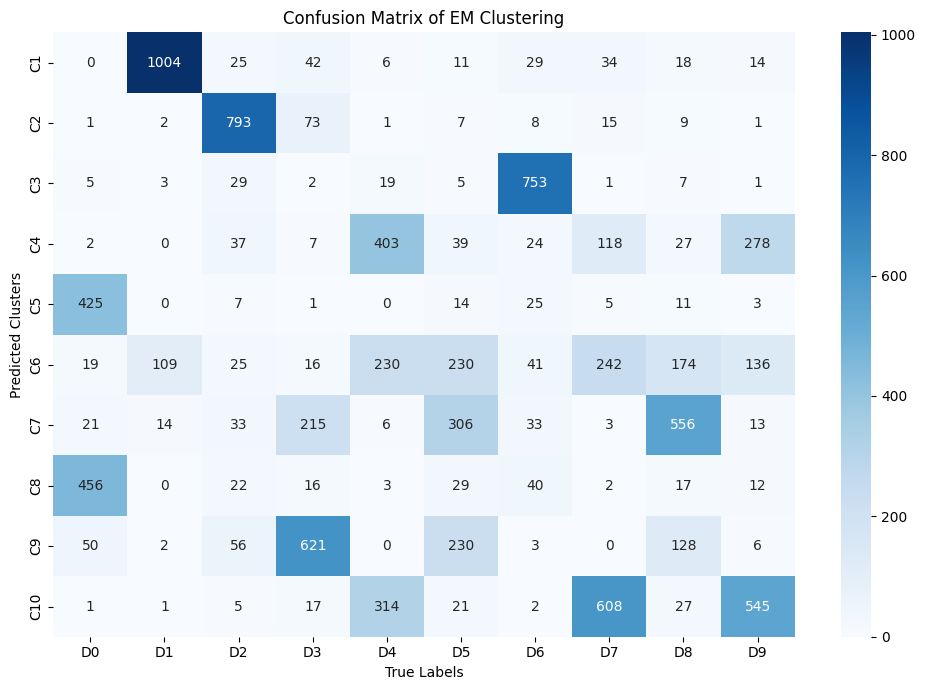

In [8]:
# Load and preprocess data
images = read_mnist_images("dataset/t10k-images.idx3-ubyte")
labels = read_mnist_labels("dataset/t10k-labels.idx1-ubyte")

resized = preprocess_mnist(images)
binarized = binarize_images(resized)

# Run EM Clustering
responsibility, params, mixing = em_clustering(binarized, n_clusters=10)

# Evaluate
confusion = evaluate_clusters(responsibility, labels, n_clusters=10)
plot_confusion_matrix(confusion)